In [1]:
# https://stackoverflow.com/questions/45350891/fitting-a-polynomial-using-np-polyfit-in-3-dimensions
# https://math.stackexchange.com/questions/1786495/estimating-the-curvature-of-a-discretized-curve-in-3d-with-cubic-splines

In [265]:
# %matplotlib qt
%load_ext autoreload
%autoreload 2
from utils.utils_IO import load_object, write_video, read_frame_at_idx
from utils.polyfitting import fit_3D_polynomial, \
        fit_polynomials_per_frame, \
        eval_3D_polynomials, \
            eval_polynomials_per_frame, compute_curvature_per_frame, compute_curvature_function 
import numpy as np
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
import cv2
from pathlib import Path
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm
import re
from typeguard import typechecked
from typing import List, Callable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
data_dict = load_object('/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/data_dict')

In [110]:
trial_number = 0
example_trial = data_dict["trials"]["Joao"]["pre"][trial_number]
video_path = Path(data_dict["video_paths"]["Joao"]["pre"]) / "concatenated_tracking.avi"
reproj_path = Path(f'/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/{video_path.parent.stem}') / "reprojections.mov"
if not Path.is_file(reproj_path):
    raise ValueError(f"No reprojections for {video_path.parent.stem}")

In [171]:
# Collect columns with chin 
# chin_base, chin_1_4, chin_mid, chin_3_4, chin_end
chin_trial_df = example_trial.filter(regex='chin')
chin_trial_arr = np.reshape(chin_trial_df.values, (chin_trial_df.values.shape[0], -1, 3))
# Get bodypart names
bp_names = []
for col in chin_trial_df.columns:
    if col[0] not in bp_names:
        bp_names.append(col[0])
print(chin_trial_arr.shape)

(1098, 5, 3)


In [172]:
# fit polynomial to a sequence of time pts
coeffs_all_frames = fit_polynomials_per_frame(data_arr = chin_trial_arr, degree = 2)

100%|██████████| 1098/1098 [00:00<00:00, 4919.74it/s]


In [242]:
interpolation_points = np.linspace(0,5,200)

In [243]:
evals = eval_polynomials_per_frame(coeffs_all_frames, interpolation_points)

100%|██████████| 1098/1098 [00:00<00:00, 13065.96it/s]


In [256]:
curvatures = compute_curvature_per_frame(coeffs_all_frames=coeffs_all_frames, 
                                         interpolation_points=interpolation_points)

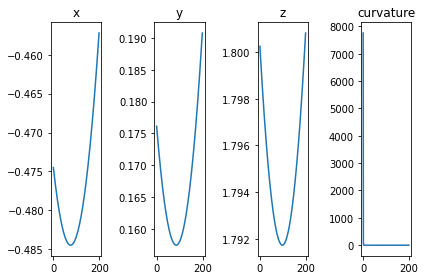

In [264]:
frame_idx = 12
plt.subplot(141)
plt.plot(evals[frame_idx, 0, :])
plt.title('x')
plt.subplot(142)
plt.plot(evals[frame_idx, 1, :])
plt.title('y')
plt.subplot(143)
plt.plot(evals[frame_idx, 2, :])
plt.title('z')
plt.subplot(144)
plt.plot(curvatures[frame_idx,:])
plt.title('curvature')
plt.tight_layout()

TODO: 
* change the code below to use the above functions
* subtract the chin base coords from all other points, so the 3d plot is always centered and interpretable
* verify the curvature func, it outputs weird values (always monotonously decreasing)

In [10]:
# Sun's version
save_dir = Path("./spline_outputs").resolve()
save_dir.mkdir(exist_ok=True, parents=True)

poly_degree = 2
start_frame = 500
poly_coeffs = []
num_interp_points = 20
print('chin_trial_arr: ', chin_trial_arr.shape)
for frame_idx in tqdm(range(start_frame, chin_trial_arr.shape[0])):
    chin_frame_points = chin_trial_arr[frame_idx]
    # Normalize to 0,1 in each dimension
    # Normalize x, y, z
    for i in range(3):
        chin_min = np.min(chin_frame_points[:, i])
        chin_max = np.max(chin_frame_points[:, i])
        chin_frame_points[:, i] = (chin_frame_points[:, i] - chin_min) / (chin_max - chin_min)
    t = np.arange(chin_frame_points.shape[0])
    ti = np.linspace(0, chin_frame_points.shape[0] - 1, num_interp_points)
    x = chin_frame_points[:, 0]
    y = chin_frame_points[:, 1]
    z = chin_frame_points[:, 2]
    
    xi = np.linspace(np.min(x), np.max(x), num_interp_points)
    yi = np.linspace(np.min(y), np.max(y), num_interp_points)

    # rbfi = interpolate.Rbf(x, y, z)
    # bvspline = interpolate.SmoothBivariateSpline(x, y, z, kx=2, ky=2)
    # zi = rbfi(xi, yi)
    # zi = bvspline(xi, yi)

    fitx = np.polyfit(t, x, poly_degree)
    fity = np.polyfit(t, y, poly_degree)
    fitz = np.polyfit(t, z, poly_degree)
    poly_coeffs.append([fitx, fity, fitz])    
    

    curvature_func = compute_curvature_function(fitx, fity, fitz)   
    max_curve = -np.inf
    for tii in t[1:]:
        if curvature_func(tii) > max_curve:
            max_curve = curvature_func(tii)
            max_curve_idx = tii

    xi = np.polyval(fitx, ti)
    yi = np.polyval(fity, ti)
    zi = np.polyval(fitz, ti)

    x_curve = np.polyval(fitx, max_curve_idx)
    y_curve = np.polyval(fity, max_curve_idx)
    z_curve = np.polyval(fitz, max_curve_idx)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=xi, ys=yi, zs=zi)
    ax.scatter(x, y, z)
    ax.scatter(x_curve, y_curve, z_curve, c="r")
    ax.view_init(elev=-90, azim=-90)
    ax.title.set_text(f"$\kappa$: {max_curve}")

    for i, txt in enumerate(range(chin_frame_points.shape[0])):
        if 'base' in bp_names[i] or 'end' in bp_names[i]:
            ax.text(x[i], y[i], z[i], bp_names[i])

    ax.axes.set_xlim3d([0, 1])
    ax.axes.set_ylim3d([0, 1])
    ax.axes.set_zlim3d([0, 1])

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.xaxis.set_tick_params(labelsize=0)
    ax.yaxis.set_tick_params(labelsize=0)
    ax.zaxis.set_tick_params(labelsize=0)
    ax.set_axis_off() 
    ax.set

    fig.canvas.draw()
    # Now we can save it to a numpy array.
    chin_plot_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    chin_plot_image = chin_plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close("all")
    video_frame = read_frame_at_idx(video_path, frame_idx)
    # reproj_frame = read_frame_at_idx(reproj_path, frame_idx)
    width = chin_plot_image.shape[1]
    height = chin_plot_image.shape[0]
    dim = (width, height)
    #vis = np.concatenate((chin_plot_image, cv2.resize(video_frame, dim), cv2.resize(reproj_frame, dim)), axis=1)
    vis = np.concatenate((chin_plot_image, cv2.resize(video_frame, dim)), axis=1)
    cv2.imwrite(str(save_dir / f"frame_{frame_idx}.png"), vis)
poly_coeffs = np.asarray(poly_coeffs)



chin_trial_arr:  (1098, 5, 3)


100%|██████████| 598/598 [02:44<00:00,  3.63it/s]


In [11]:
write_video(image_dir=str(save_dir), out_file="chin_movie_3.mov", fps=50)